In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.colors as mcolors
import sns
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


files = Path("../clean_data").glob("*.parquet")

df = pd.concat(
    (pd.read_parquet(f) for f in files),
    ignore_index=True
)
df_model = df.copy()

col_num = [
    't2m_mean', 't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
    'tp_sum', 'e_sum', 'ssrd_sum', 'lai_total','ws_mean'
]


features_to_vif = [
    't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'blh_mean',
    'tcc_mean', 'soil_moisture', 'tp_sum', 'e_sum', 'ssrd_sum', 'lai_total', 'ws_mean'
]

X = df_model[features_to_vif].dropna()
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

vif_data = vif_data[vif_data["feature"] != "const"].sort_values("VIF", ascending=False)

print(vif_data)
#

          feature        VIF
4        skt_mean  99.650768
1         t2m_max  43.729447
2         t2m_min  36.886720
11       ssrd_sum  13.209564
6        blh_mean   6.101081
3        d2m_mean   4.462932
10          e_sum   3.720322
8   soil_moisture   3.017844
13        ws_mean   1.956339
7        tcc_mean   1.803644
9          tp_sum   1.298556
5         sp_mean   1.149366
12      lai_total   1.141452


Z uwagi na poprzednie macierze korelacji oraz VIF
Zostawie t2m_mean, usune skt_mean, zrobie nową koloumne temp_range = t2m_max - t2m_min - > amplituda dobowa


In [5]:
col_selected = [
    'latitude', 'longitude','month', 'dayofyear',
    't2m_mean',      # Główna temperatura
    'd2m_mean',      # Wilgotność (punkt rosy)
    'sp_mean',       # Ciśnienie (VIF bardzo niski, warto zostawić)
    'blh_mean',      # Wysokość warstwy granicznej
    'tcc_mean',      # Zachmurzenie
    'tp_sum',        # Opady
    'e_sum',         # Parowanie
    'ssrd_sum',      # Promieniowanie
    'lai_total',     # Roślinność
    'ws_mean'        # Prędkość wiatru
]

df['temp_range'] = df['t2m_max'] - df['t2m_min']
col_selected.append('temp_range') # tmax - tmin

df_model = df[col_selected]
df_model.head(5)

,latitude,longitude,month,dayofyear,t2m_mean,d2m_mean,sp_mean,blh_mean,tcc_mean,tp_sum,e_sum,ssrd_sum,lai_total,ws_mean,temp_range
0,38.5,-6.0,1,1,10.289764,9.086151,97126.875000,434.331635,0.994072,0.046730,-0.010526,134144.0,3.939392,2.813566,1.722412
1,38.5,-6.0,1,1,11.305145,7.514069,97150.828125,462.986633,0.601974,0.000477,-0.171009,2261120.0,3.940826,2.670740,5.799316
2,38.5,-6.0,1,2,7.491089,6.499939,97018.609375,52.482376,0.839874,0.006199,0.005607,210752.0,3.942078,1.328706,1.619751
3,38.5,-6.0,1,2,11.852875,8.012268,96761.234375,453.875336,0.960083,0.005722,-0.164966,1872832.0,3.943573,1.811240,4.601807
4,38.5,-6.0,1,3,9.341919,7.491516,96438.406250,140.091217,0.609650,0.008583,0.004828,222784.0,3.944946,2.070344,1.900024


In [ ]:
X = df[col_selected]
y = df['soil_moisture']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_comparison = {}

base_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

for name, model in base_models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    final_comparison[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 300, 500],
    'xgb__max_depth': [4, 6, 8],
    'xgb__learning_rate': [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_xgb.fit(X_train, y_train)

best_model_pipe = grid_xgb.best_estimator_
y_pred_xgb = best_model_pipe.predict(X_test)

final_comparison['XGBoost (Optimized)'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb)
}

results_df = pd.DataFrame(final_comparison).T
print("\n=== FINALNE PORÓWNANIE MODELI ===")
print(results_df.sort_values(by='R2', ascending=False))

best_xgb_internal = best_model_pipe.named_steps['xgb']
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(best_xgb_internal.feature_importances_, index=col_selected).sort_values(ascending=True)
feat_imp.plot(kind='barh', color='teal')
plt.title('Co najbardziej wpływa na wilgotność gleby w Hiszpanii? (XGBoost Importance)')
plt.xlabel('Względna ważność cechy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='coral')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Wartości Rzeczywiste (soil_moisture)')
plt.ylabel('Przewidziane przez XGBoost')
plt.title(f'Jak dobrze model przewiduje? (R2 = {r2_score(y_test, y_pred_xgb):.3f})')
plt.tight_layout()
plt.show()

print(f"\nNajlepsze parametry XGBoost: {grid_xgb.best_params_}")

Trenuję modele bazowe...


In [ ]:
errors = y_pred_xgb - y_test.values

plt.figure(figsize=(8, 7))

mn = min(y_test.min(), y_pred_xgb.min())
mx = max(y_test.max(), y_pred_xgb.max())
lims = [mn, mx]

sc = plt.scatter(
    y_test,
    y_pred_xgb,
    c=errors,
    cmap='coolwarm',
    alpha=0.6,
    s=25,
    edgecolors='none'
)

plt.plot(lims, lims, '--', color='black', lw=2, label="Idealne dopasowanie")

plt.xlabel("Rzeczywista wilgotność gleby (ERA5)", fontsize=12)
plt.ylabel("Predykcja modelu XGBoost", fontsize=12)
plt.title("Analiza błędów predykcji: Rzeczywiste vs Przewidziane", fontsize=14)

cbar = plt.colorbar(sc)
cbar.set_label("Wartość błędu (Predykcja - Rzeczywistość)", rotation=270, labelpad=20)

plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
X_future = X_test.copy()

X_future['t2m_mean'] = X_future['t2m_mean'] + 2.0

y_future_pred = best_model_pipe.predict(X_future)

diff = (y_future_pred.mean() - y_pred_xgb.mean()) / y_pred_xgb.mean() * 100
print(f"Przy wzroście temperatury o 2 stopnie, średnia wilgotność gleby spadnie o: {diff:.2f}%")

In [ ]:
yearly_temp = df.groupby('year')['t2m_mean'].mean()

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(yearly_temp.index, yearly_temp.values)

print(f"Temperatura w Twoich danych rośnie średnio o {slope:.4f} °C na rok.")

In [ ]:
df_2040 = df[df['year'] >= 2020].copy()

df_2040['year'] = df_2040['year'] + 15

future_warmth = 15 * slope
df_2040['t2m_mean'] += future_warmth

df_2040['tp_sum'] *= 0.95

X_2040 = df_2040[col_selected]

In [ ]:
df_2040['predicted_soil_moisture'] = best_model_pipe.predict(X_2040)

historical_avg = df.groupby('year')['soil_moisture'].mean()
future_val = df_2040['predicted_soil_moisture'].mean()

plt.figure(figsize=(12, 6))
plt.plot(historical_avg.index, historical_avg.values, label='Dane historyczne (ERA5)', marker='o')

plt.scatter([2040], [future_val], color='red', s=100, label='Prognoza modelu na 2040', zorder=5)
plt.plot([historical_avg.index[-1], 2040], [historical_avg.values[-1], future_val], 'r--')

z = np.polyfit(historical_avg.index, historical_avg.values, 1)
p = np.poly1d(z)

plt.plot(historical_avg.index, p(historical_avg.index), "r-", alpha=0.3, label='Trend historyczny')

plt.title("Prognoza spadku wilgotności gleby w Hiszpanii do 2040 roku")
plt.xlabel("Rok")
plt.ylabel("Wilgotność gleby")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_model_pipe)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:

results = X_test[['latitude', 'longitude']].copy()
results['real'] = y_test
results['pred'] = y_pred_xgb
results['abs_error'] = abs(results['real'] - results['pred'])

plt.figure(figsize=(12, 8))
sc = plt.scatter(results['longitude'], results['latitude'],
                 c=results['abs_error'], cmap='YlOrRd', s=10)
plt.colorbar(sc, label='Błąd bezwzględny (MAE)')
plt.title("Gdzie model myli się najbardziej? (Analiza przestrzenna)")
plt.xlabel("Długość geograficzna")
plt.ylabel("Szerokość geograficzna")
plt.show()

# Temperatura

In [6]:
features_temp = [
    'year', 'month', 'dayofyear', 'latitude', 'longitude',
    'sp_mean',    # Ciśnienie
    'tcc_mean',   # Zachmurzenie (kluczowe dla temp)
    'tp_sum',     # Opady
    'ssrd_sum',   # Promieniowanie słoneczne
    'ws_mean'     # Wiatr
]

Trenowanie modeli...
Regresja Liniowa ukończony
Random Forest ukończony
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Najlepsze parametry XGBoost: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__tree_method': 'hist'}
XGBoost (GridSearch) ukończony

Podsumowanie wyników:
                  Model       MAE       R^2
2  XGBoost (GridSearch)  2.036961  0.904785
1         Random Forest  2.334725  0.875045
0      Regresja Liniowa  4.222033  0.608370


C:\Users\oliwi\AppData\Local\Temp\ipykernel_10024\2607357613.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R^2', y='Model', data=df_res, palette='viridis')


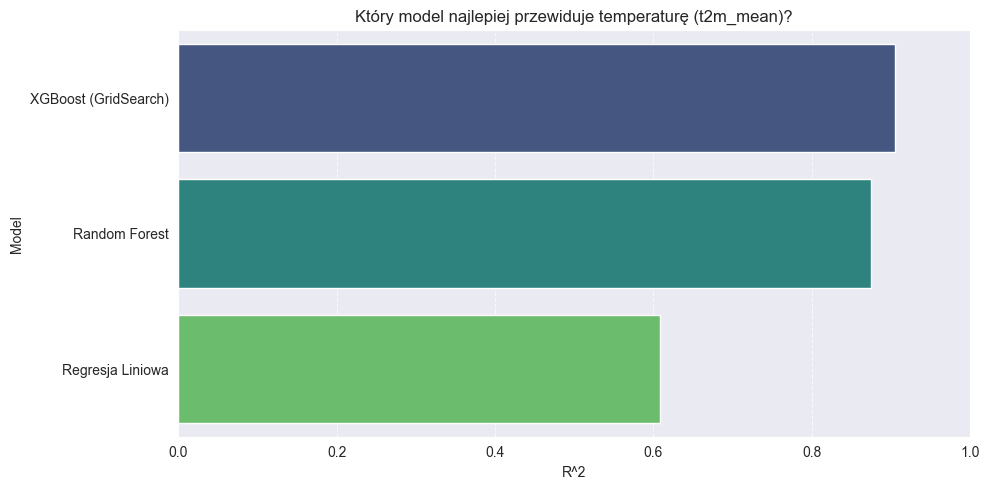

In [9]:
X = df[features_temp]
y = df["t2m_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5],
    'model__colsample_bytree': [0.3, 0.7],
    'model__tree_method': ['hist'],
    'model__n_jobs': [-1]
}


pipelines = {
    "Regresja Liniowa": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Random Forest": Pipeline([
        ("model", RandomForestRegressor(
            n_estimators=80,
            max_depth=10,
            min_samples_leaf=50,
            n_jobs=-1,
            random_state=42
        ))
    ]),


    "XGBoost (GridSearch)": GridSearchCV(
        Pipeline([
            ("model", xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
        ]),
        param_grid=xgb_params,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=1
    )
}

results = []

print("Trenowanie modeli...")
for name, model in pipelines.items():

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    if name == "XGBoost (GridSearch)":
        print(f"Najlepsze parametry XGBoost: {model.best_params_}")

    results.append({'Model': name, 'MAE': mae, 'R^2': r2})
    print(f"{name} ukończony")

df_res = pd.DataFrame(results).sort_values("R^2", ascending=False)
print("\nPodsumowanie wyników:")
print(df_res)

plt.figure(figsize=(10, 5))
sns.barplot(x='R^2', y='Model', data=df_res, palette='viridis')
plt.title('Który model najlepiej przewiduje temperaturę (t2m_mean)?')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()